In [ ]:
!pip install ohmeow-blurr -q
!pip install bert-score -q
!pip install sacremoses

import pandas as pd
import torch
from transformers import *
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *
import nltk
nltk.download('punkt')

     |████████████████████████████████| 81 kB 2.7 MB/s 
     |████████████████████████████████| 59 kB 5.0 MB/s 
     |████████████████████████████████| 1.2 MB 32.7 MB/s 
     |████████████████████████████████| 96 kB 4.2 MB/s 
     |████████████████████████████████| 4.2 MB 35.6 MB/s 
     |████████████████████████████████| 197 kB 32.7 MB/s 
     |████████████████████████████████| 346 kB 36.1 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 6.6 MB 33.7 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
     |████████████████████████████████| 596 kB 36.2 MB/s 
     |████████████████████████████████| 140 kB 8.2 MB/s 
     |████████████████████████████████| 212 kB 48.4 MB/s 
     |████████████████████████████████| 1.1 MB 39.0 MB/s 
     |████████████████████████████████| 127 kB 53.8 MB/s 
     |████████████████████████████████| 144 kB 45.0 MB/s 
     |████████████████████████████████| 271 kB 46.3 MB/s 
     |███████████████████

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#Get data
df = pd.read_csv('/content/datos_modifiedComa.csv', error_bad_lines=False, sep=',')
df = df[['snt_id','source_snt','simplified_snt']]

articles = df.head(638)


n_labels = len(articles["source_snt"].unique())
print(n_labels)
articles

638


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,snt_id,source_snt,simplified_snt
0,G11.1_2892036907_1,"In the modern era of automation and robotics, autonomous vehicles are currently the focus of academic and industrial research, related to drones.",Current academic and industrial research is interested in autonomous vehicles.
1,G11.1_2892036907_2,"With the ever increasing number of unmanned aerial vehicles getting involved in activities in the civilian and commercial domain, there is an increased need for autonomy in these systems too, related to drones.",Drones are increasingly used in the civilian and commercial domain and need to be autonomous.
2,G11.1_2892036907_3,"Due to guidelines set by the governments regarding the operation ceiling of civil drones, road-tracking based navigation is garnering interest, related to drones.","Governments set guidelines on the operation ceiling of civil drones. So, road-tracking based navigation is attracting interest."
3,G11.1_2892036907_4,"In an attempt to achieve the above mentioned tasks, we propose an imitation learning based, data-driven solution to UAV autonomy for navigating through city streets by learning to fly by imitating an expert pilot, related to drones.","Researchers propose data-driven solutions allowing drones to autonomously navigate city streets, learning to fly by imitating an expert pilot."
4,G11.1_2892036907_5,"Derived from the classic image classification algorithms, our classifier has been constructed in the form of a fast 39-layered Inception model, that evaluates the presence of roads using the tomographic reconstructions of the input frames, related to drones.","The algorithm, based on the Inception model, detects roads using tomographic reconstructions. The Inception model is an extension of classic image classification algorithms."
...,...,...,...
633,M7_39_2,"The purpose of this paper was to conduct a systematic review and meta-analysis of experimental studies designed to investigate the effects of weekly training frequency on hypertrophic adaptations, related to How many training per week for hypetrophy?.",The purpose of this paper was to conduct a review and analysis of multiple studies investigating the effects of weekly training frequency on hypertrophy.
634,M7_39_3,"Results showed no significant difference between higher and lower frequency on a volume-equated basis, related to How many training per week for hypetrophy?.","Results showed no significant difference between higher and lower frequency with the same training volume (number of exercises, sets, etc.)."
635,M7_39_4,"Meta-regression analysis of non-volume-equated studies showed a significant effect favoring higher frequencies, although the overall difference in magnitude of effect between frequencies of 1 and 3+ days per week was modest, related to How many training per week for hypetrophy?.","Analysis of studies with different training volumes showed better results for higher frequencies, although the difference between frequencies of 1 and 3+ days per week was small."
636,M7_39_5,"In conclusion, there is strong evidence that resistance training frequency does not significantly or meaningfully impact muscle hypertrophy when volume is equated, related to How many training per week for hypetrophy?.","In conclusion, there is strong evidence that resistance training frequency does not significantly impact muscle hypertrophy when training volume is the same."


In [ ]:
#Import model
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In [ ]:
text_gen_kwargs = {}
if hf_arch in ["bart", "t5"]:
    text_gen_kwargs = {**hf_config.task_specific_params["summarization"], **{"max_length": 50, "min_length": 10}}

# not all "summarization" parameters are for the model.generate method ... remove them here
generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())
for k in text_gen_kwargs.copy():
    if k not in generate_func_args:
        del text_gen_kwargs[k]

if hf_arch == "mbart":
    text_gen_kwargs["decoder_start_token_id"] = hf_tokenizer.get_vocab()["en_XX"]
    
tok_kwargs = {}
if hf_arch == "mbart":
    tok_kwargs["src_lang"], tok_kwargs["tgt_lang"] = "en_XX", "en_XX"

In [ ]:
batch_tokenize_tfm = Seq2SeqBatchTokenizeTransform(
    hf_arch,
    hf_config,
    hf_tokenizer,
    hf_model,
    max_length=256,
    max_target_length=130,
    tok_kwargs=tok_kwargs,
    text_gen_kwargs=text_gen_kwargs,
)

blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=batch_tokenize_tfm), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader("source_snt"), get_y=ColReader("simplified_snt"), splitter=RandomSplitter())
dls = dblock.dataloaders(articles, bs=2)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"<s> We suggest that these changes may be completely separate phenomena based on: (1) the weak correlation between the change in muscle size and the change in muscle strength after training; (2) the loss of muscle mass with detraining, yet a maintenance of muscle strength; and (3) the similar muscle growth between low-load and high-load resistance training, yet divergent results in strength, related to The problem Of muscle hypertrophy: Revisited.</s>","We suggest that these changes may be based on: (1) the weak correlation between the change in muscle size and the change in muscle strength after training; (2) the loss of muscle mass with the interruption of training, yet a maintenance of muscle strength; and (3) the similar muscle growth between low-load and high-load strength training, yet different results in strength."
1,"<s> The purpose of this systematic review was to 1) present the current state of literature regarding the effects of resistance training on functional mobility outcomes for older adults with skeletal muscle function deficits and 2) provide clinicians with practical guidelines that can be used with seniors during resistance training, or to encourage exercise, related to Resistance training for muscle function deficits.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>",The purpose of this review was to present the effects of strength training on mobility for older adults with muscle function deficits and to provide guidelines that can be used with seniors during strength training.


In [ ]:
seq2seq_metrics = {
    "rouge": {
        "compute_kwargs": {"rouge_types": ["rouge1", "rouge2", "rougeL", "rougeLsum"], "use_stemmer": True},
        "returns": ["rouge1", "rouge2", "rougeL", "rougeLsum"],
    },
    "bertscore": {"compute_kwargs": {"lang": "en"}, "returns": ["precision", "recall", "f1"]},
}

In [ ]:
model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=CrossEntropyLossFlat(),
    cbs=learn_cbs,
    splitter=partial(blurr_seq2seq_splitter, arch=hf_arch),
)

# learn = learn.to_native_fp16() #.to_fp16()
learn.freeze()
#learn.summary()

SuggestedLRs(minimum=3.311311302240938e-05, steep=9.12010818865383e-07, valley=3.0199516913853586e-05, slide=6.918309736647643e-06)

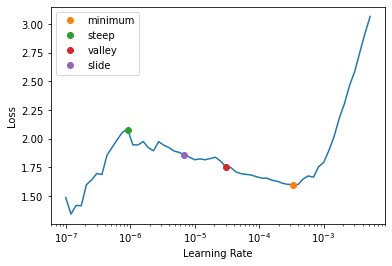

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(5, lr_max=3.311311302240938e-05, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,rougeLsum,bertscore_precision,bertscore_recall,bertscore_f1,time
0,0.751911,1.329295,0.654133,0.492930,0.624001,0.623183,0.938153,0.939857,0.938774,03:28
1,0.591264,1.522717,0.650850,0.482689,0.619368,0.617459,0.938071,0.940030,0.938831,02:36
2,0.277291,1.713570,0.654740,0.486993,0.621420,0.621422,0.940175,0.940177,0.939961,02:34
3,0.110774,1.970146,0.661788,0.492981,0.627979,0.626421,0.938934,0.941460,0.939970,02:35
4,0.053811,2.154701,0.657796,0.490822,0.624359,0.623141,0.938406,0.940822,0.939396,02:36


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

In [ ]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=250)

,text,target,prediction
0,"Eight healthy physically active male subjects (age 21,4±4,8 yr, body mass (BM) 79,3±11,9 kg, peak oxygen uptake (VO2peak) 48,1±4,8 mL·kg−1·min−1, leg extension one repetition maximum (1RM) 104±20 kg; values are mean ± SD) who had been participating in regular exercise (3 times wk−1 for >6 months) volunteered for this study, related to Alcohol interfer with recovery and adaptation to training.",Eight healthy physically active men (3 trainings per week for at least 6 months) volunteered for this study.,"[ Eight healthy physically active male subjects (age 21,4±4,8 yr, body mass (BM) 79,3±11, In conclusion, passive, low-intensity stretch does not appear to confer beneficial changes in muscle size and architecture. However, limited evidence suggests]"


In [ ]:
#Use test data to generate simplifications
df = pd.read_csv('/content/simpletext_task3_test.csv',  sep=',')
df['simplified_snt'] = " "
#modify run id for different runs
df['run_id'] = 'HULAT-UC3M11'
#the generation of the simplifications has been automatic
df['manual'] = 0

In [ ]:
#the model cannot process all 100.000+ entries of the test data in one go, a subset of the test data must be chosen to be executed
#it doesnt have to strictly be the head of the dataframe, for example rows 2000-3999 could be chosen
df = df.head(100)
df

,snt_id,source_snt,doc_id,query_id,query_text,simplified_snt,run_id,manual
0,G01.1_1564531496_1,In this short paper we describe the architectural concept of a Citizen Digital Assistant (CDA) and preliminary results of our implementation.,1564531496,G01.1,Digital assistant,,HULAT-UC3M11,0
1,G01.1_1564531496_2,"A CDA is a mobile user device, similar to a Personal Digital Assistant (PDA).",1564531496,G01.1,Digital assistant,,HULAT-UC3M11,0
2,G01.1_1564531496_3,"It supports the citizen when dealing with public authorities and proves his rights - if desired, even without revealing his identity.",1564531496,G01.1,Digital assistant,,HULAT-UC3M11,0
3,G01.1_1564531496_4,Requirements for secure and trusted interactions in e-Government solutions are presented and shortcomings of state of the art digital ID cards are considered.,1564531496,G01.1,Digital assistant,,HULAT-UC3M11,0
4,G01.1_1564531496_5,"The Citizen Digital Assistant eliminates these shortcomings and enables a citizen-controlled communication providing the secure management of digital documents, identities, and credentials.",1564531496,G01.1,Digital assistant,,HULAT-UC3M11,0
...,...,...,...,...,...,...,...,...
95,G01.1_2967569942_8,We show that our solution is effective by uniquely identifying 31 devices among 33 of the tested devices: each of these devices is identified by a unique feature vector using the Bag Of Words representation.,2967569942,G01.1,Digital assistant,,HULAT-UC3M11,0
96,G01.1_1530854586_1,"This study explored the potential of the application of wireless and mobile computing technologies to be used in improving the efficiency of patient care and education and future developments in information and communication technologies to support healthcare professionals and medical students in healthcare research, medical education and training.",1530854586,G01.1,Digital assistant,,HULAT-UC3M11,0
97,G01.1_1530854586_2,"The design used for this study was a systematic review of published materials obtained from EMBASE and MEDLINE online databases, and the Cochrane Library database, including personal observations.",1530854586,G01.1,Digital assistant,,HULAT-UC3M11,0
98,G01.1_1530854586_3,"Today, more than 50% of healthcare professionals and medical students are using Personal Digital Assistant with expected growth of more than 75% by year-end 2007.",1530854586,G01.1,Digital assistant,,HULAT-UC3M11,0


In [ ]:
pip install swifter

     |████████████████████████████████| 647 kB 5.0 MB/s 
     |████████████████████████████████| 280 kB 59.1 MB/s 
  Created wheel for swifter: filename=swifter-1.1.3-py3-none-any.whl size=13078 sha256=615d87a308a657d5b4209b8d24e205a3fcadf704ef2a533587077e0a8d385b09
  Stored in directory: /root/.cache/pip/wheels/e8/1a/1b/46aa7b0fac16d3ce1bccaac14bfe4fad972642217ae78d8160
Successfully built swifter
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [ ]:
import swifter

In [ ]:
#generate simplifications
def simplify (snt):
  output = learn.blurr_generate(snt, num_return_sequences=1)
  final = output[0]['generated_texts']
  return(final)


df['simplified_snt'] = df.swifter.apply(lambda row: simplify(row['source_snt']),axis=1)


Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
df = df[['run_id','manual','snt_id','simplified_snt']]
df

,run_id,manual,snt_id,simplified_snt
0,HULAT-UC3M11,0,G01.1_1564531496_1,"In this paper we describe the architectural concept of a Citizen Digital Assistant (CDA) and preliminary results of our implementation of the CDA in the cloud (based on Google’s cloud services) and in the real world (on smartphones, tablets, computers, etc)."
1,HULAT-UC3M11,0,G01.1_1564531496_2,"A CDA is a mobile user device, similar to a Personal Digital Assistant (PDA), which is a personal digital assistant device (personal digital assistant) for mobile users. The device is used by the user to control their mobile phone or other device with the help of an app."
2,HULAT-UC3M11,0,G01.1_1564531496_3,"It supports the citizen when dealing with public authorities and proves his rights - if desired, even without revealing his identity. It also provides information about his rights when he is in public view. For confidential support call the Samaritans on 08457 90 90 90 or visit a local Samaritans branch, see www.samaritans.org for details."
3,HULAT-UC3M11,0,G01.1_1564531496_4,"Requirements for secure and trusted interactions in e-Government solutions are presented and shortcomings of state of the art digital ID cards are considered. For confidential support call the Samaritans on 08457 90 90 90, visit a local Samaritans branch, or see www.samaritans.org for details."
4,HULAT-UC3M11,0,G01.1_1564531496_5,"assistant enables a citizen-controlled communication providing the secure management of digital documents, identities, and credentials. The Citizen Digital Assistant eliminates these shortcomings and enables the citizen to control the digital communication of their interests and activities with the help of the digital assistant’s voice and image."
...,...,...,...,...
95,HULAT-UC3M11,0,G01.1_2967569942_8,We show that our solution is effective by uniquely identifying 31 devices among 33 of the tested devices: each of these devices is identified by a unique feature vector using the Bag Of Words representation (a representation of words used to identify objects in the Bag of Words representation).
96,HULAT-UC3M11,0,G01.1_1530854586_1,"This study explored the potential of the application of wireless and mobile computing technologies to improve the efficiency of patient care and education and future developments in information and communication technologies to support healthcare professionals and medical students in healthcare research, medical education and training. For confidential support call the Samaritans on 08457 90 90 90 or visit a local Samaritans branch, see www.samaritans.org for details."
97,HULAT-UC3M11,0,G01.1_1530854586_2,"The design used for this study was a systematic review of published materials obtained from EMBASE and MEDLINE online databases, and the Cochrane Library database, including personal observations. The results of this study were published in The Cochrane Database of Systematic Reviews."
98,HULAT-UC3M11,0,G01.1_1530854586_3,More than 50% of healthcare professionals and medical students are using Personal Digital Assistant with expected growth of more than 75% by year-end 2007 (2007 end of the current financial year) and expected to be used by 75% of medical students and professionals by the end of 2007.


In [ ]:
df.to_csv('runA.csv', index=False,sep ='\t')